In [7]:
from pickle import load
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from sys import argv
from Model import Player, Team, Confrontation, LineUp
from utils import *
import seaborn as sns
plt.rcParams["figure.figsize"] = (16,9)

In [59]:
def display_heatmap(matrix, index, title):
    g = sns.heatmap(matrix,annot=True,xticklabels=index,yticklabels=index,linewidths=.5, fmt=".3f", cmap='Blues', vmin=-1, vmax=1)
    g.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = True, labeltop=True)
    g.set_xticklabels(g.get_xticklabels(), fontsize = 12,rotation=90, horizontalalignment='right')
    g.set_yticklabels(g.get_yticklabels(), fontsize = 12,rotation=0, horizontalalignment='right')
    plt.title(title, fontweight="bold", fontsize = 20)
    plt.show()

In [40]:
def generate_rankings(session, t,method, specify_technique = False, technique = None):
    
    def generate_ranking(
        specify_technique, 
        technique, 
        approach,
        time_criterion = False,
        fallback = None, 
        bradley_terry =False
    ):
        if(specify_technique):
            return method(session, technique,approach, time_criterion, fallback, bradley_terry)
        else:
            return method(session,approach, time_criterion, fallback, bradley_terry)
    
    distance_matrix_kendall = np.zeros((NB_RANKINGS, NB_RANKINGS))
    distance_matrix_spearman = np.zeros((NB_RANKINGS, NB_RANKINGS))
    players = t.players(session)
    rankings, base = [],sorted([i.name for i in players])
    rankings.append(
        ranking_to_ballot(
            index_ranking_to_name_ranking(
                generate_ranking(specify_technique, technique, "scoring") , 
                players
            ),
            base
        )
    )
    rankings.append(
        ranking_to_ballot(
            index_ranking_to_name_ranking(
                generate_ranking(specify_technique, technique,"pareto_dominance", time_criterion = False),
                players
            ),
            base
        )
    )
    rankings.append(
        ranking_to_ballot(
            index_ranking_to_name_ranking(
                generate_ranking(specify_technique, technique, "pareto_dominance", time_criterion = True),
                players
            ),
            base
        )
    )
    rankings.append(
        ranking_to_ballot(
            index_ranking_to_name_ranking(
                generate_ranking(specify_technique, technique,"witness", fallback="scoring", bradley_terry =False),
                players
            ),
            base
        )
    )
    rankings.append(
        ranking_to_ballot(
            index_ranking_to_name_ranking(
                generate_ranking(specify_technique, technique,"witness", fallback="scoring", bradley_terry = True),
                players
            ),
            base
        )
    )

    for i in range(len(rankings)):
        distance_matrix_kendall[i, i] = 1
        distance_matrix_spearman[i, i] = 1
        for j in range(i+1,len(rankings)):
            distance_matrix_kendall[i, j] += kendalltau_dist(rankings[i], rankings[j])
            distance_matrix_kendall[j, i] = distance_matrix_kendall[i, j]
            distance_matrix_spearman[i, j] += spearman_ro(rankings[i], rankings[j])
            distance_matrix_spearman[j, i] = distance_matrix_spearman[i, j]
    return distance_matrix_kendall, distance_matrix_spearman

In [41]:
def generate_global_tau_ro_matrix_for_one_specific_method(method_index):
    
    def method_index_to_method(t, method_index):
        if(method_index==0):
            return t.copeland
        if(method_index==1):
            return t.krammer_simpson
        if(method_index==2):
            return t.borda_ranking
        if(method_index==3):
            return t.stv_based_ranking
    
    global_tau, global_ro = np.zeros((NB_RANKINGS, NB_RANKINGS)), np.zeros((NB_RANKINGS, NB_RANKINGS))
    for i in tqdm(range(len(teams))):
        t = teams[i]
        method = method_index_to_method(t,method_index) 
        if(method_index < 2):
            tau, ro = generate_rankings(session,t,method , True, Player.ceteris_paribus)
        else:
            tau, ro = generate_rankings(session,t, method)
        global_tau += tau/len(teams)
        global_ro += ro/len(teams)
    return global_tau, global_ro

In [4]:
engine = create_engine("sqlite:///../2009-2010.db".format(argv[1]),echo = False)

Session = sessionmaker()
Session.configure(bind=engine)

session = Session()
teams = session.query(Team).all()
NB_RANKINGS = 5
index = [
    "scoring",
    "pareto dominance without time",
    "pareto dominance with time",
    "witness without BT", 
    "witness with BT"
]

# Comparision of the rankings of the lineups

This notebook is used to compare the rankings of the lineups used to construct the rankings of the players. A first global comparision between the ranking of the lineups is provided, then a focus is put on comparing the rankings of the lineups of one particular team and its consequences on the rankings of the players of that team.   

## Mean Tau and Ro matrices over all the teams 

In [5]:
NB_RANKINGS = 5
nb_teams = 30
distance_matrix_kendall = np.zeros((NB_RANKINGS, NB_RANKINGS))
distance_matrix_spearman = np.zeros((NB_RANKINGS, NB_RANKINGS))
for i in tqdm(range(len(teams))):
    t = teams[i]
    rankings, base = [],[]
    tmp = t.lineup_ranking(session, "scoring", False, None, False)
    tmp_ranking = []
    for i in tmp.keys():
        tmp_ranking.append(tmp[i])
        for j in tmp[i]:
            base.append(j)
    base = sorted(base)
    rankings.append(ranking_to_ballot(tmp_ranking,base))
    tmp = t.lineup_ranking(session, "pareto_dominance", False, None, False)
    tmp_ranking = []
    for i in tmp.keys():
        tmp_ranking.append(tmp[i])
    rankings.append(ranking_to_ballot(tmp_ranking,base))

    tmp = t.lineup_ranking(session, "pareto_dominance", True, None, False)
    tmp_ranking = []
    for i in tmp.keys():
        tmp_ranking.append(tmp[i])
    rankings.append(ranking_to_ballot(tmp_ranking,base))

    tmp = t.lineup_ranking(session, "witness", False, "scoring", False)
    tmp_ranking = []
    for i in tmp.keys():
        tmp_ranking.append(tmp[i])
    rankings.append(ranking_to_ballot(tmp_ranking,base))

    tmp = t.lineup_ranking(session, "witness", False, "scoring", True)
    tmp_ranking = []
    for i in tmp.keys():
        tmp_ranking.append(tmp[i])
    rankings.append(ranking_to_ballot(tmp_ranking,base))

    for i in range(len(rankings)):
        distance_matrix_kendall[i, i] = 1
        distance_matrix_spearman[i, i] = 1
        for j in range(i+1,len(rankings)):
            distance_matrix_kendall[i, j] += kendalltau_dist(rankings[i], rankings[j])/len(teams)
            distance_matrix_kendall[j, i] = distance_matrix_kendall[i, j]
            distance_matrix_spearman[i, j] += spearman_ro(rankings[i], rankings[j])/len(teams)
            distance_matrix_spearman[j, i] = distance_matrix_spearman[i, j]
index = ["scoring", "pareto dominance without time", "pareto dominance with time","witness without BT", "witness with BT"]

100%|███████████████████████████████████████████| 30/30 [01:50<00:00,  3.69s/it]


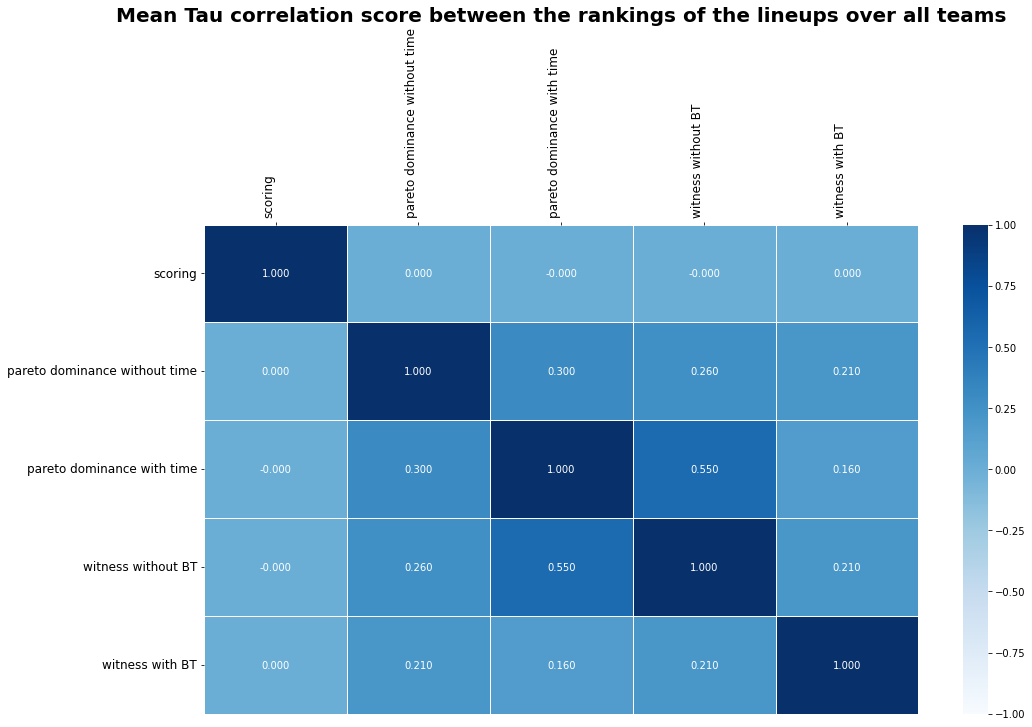

In [60]:
display_heatmap(np.round(distance_matrix_kendall, 2), index, 
               f"Mean Tau correlation score between the rankings of the lineups over all teams")

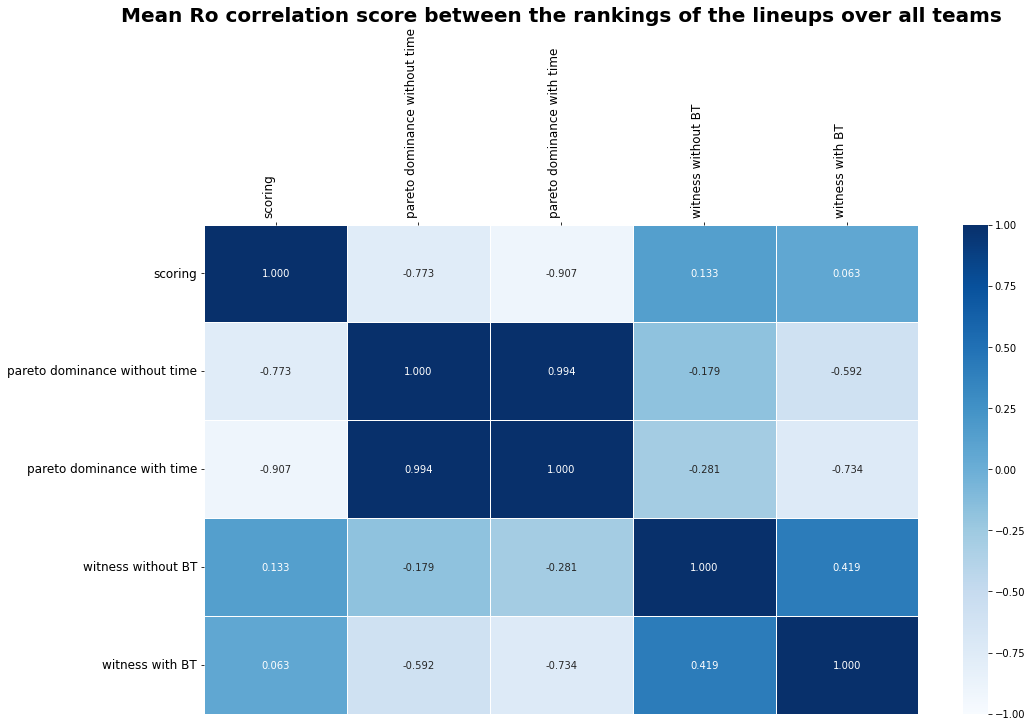

In [61]:
display_heatmap(np.round(distance_matrix_spearman, 4), index,
                f"Mean Ro correlation score between the rankings of the lineups over all teams")

## Explore the impact of changing the ranking of lineups on the methods used to generate the rankings of the players

In [48]:
#use the function generate_global_tau_ro_matrix_for_one_specific_method to generate 
#the matrix of mean correlation between the rankings of the players for each team using a specific method
# give the argument 
#0: to use the copeland method, 
#1 ro use the krammer simpson method,
#2 to use borda 
#3 to use stv
global_tau_copeland, global_ro_copeland = generate_global_tau_ro_matrix_for_one_specific_method(0)

100%|███████████████████████████████████████████| 30/30 [05:03<00:00, 10.12s/it]


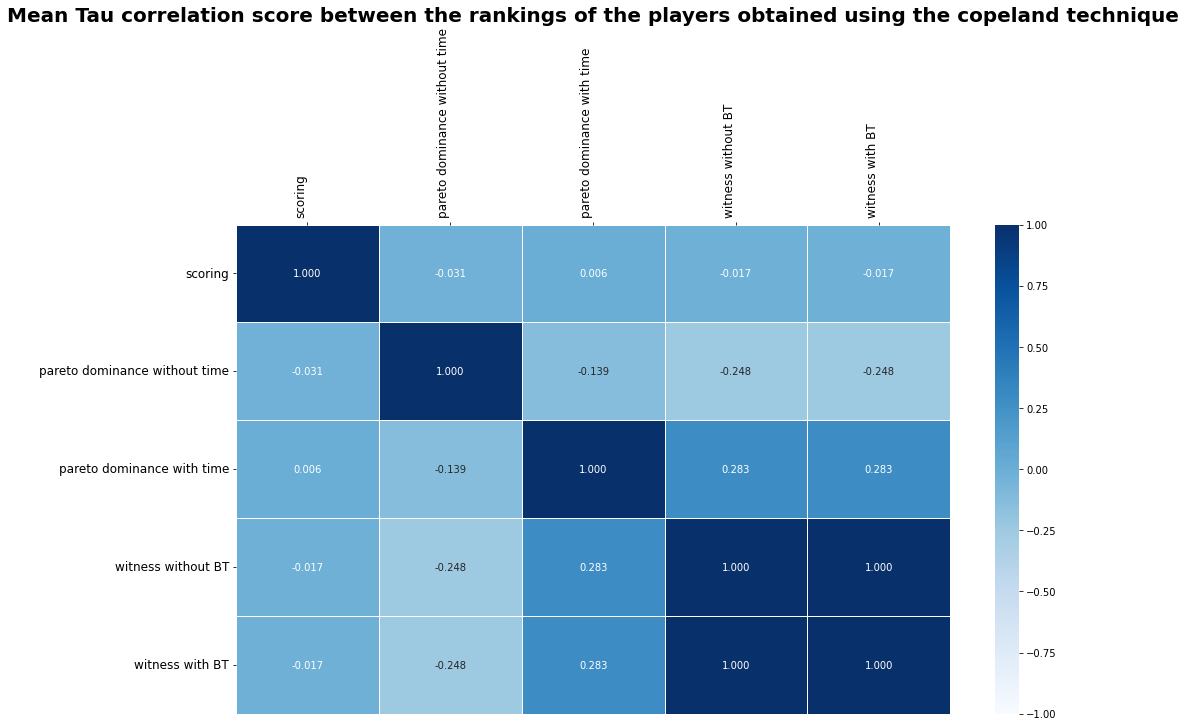

In [62]:
display_heatmap(np.round(global_tau_copeland, 4), index,
                f"Mean Tau correlation score between the rankings of the players obtained using the copeland technique")

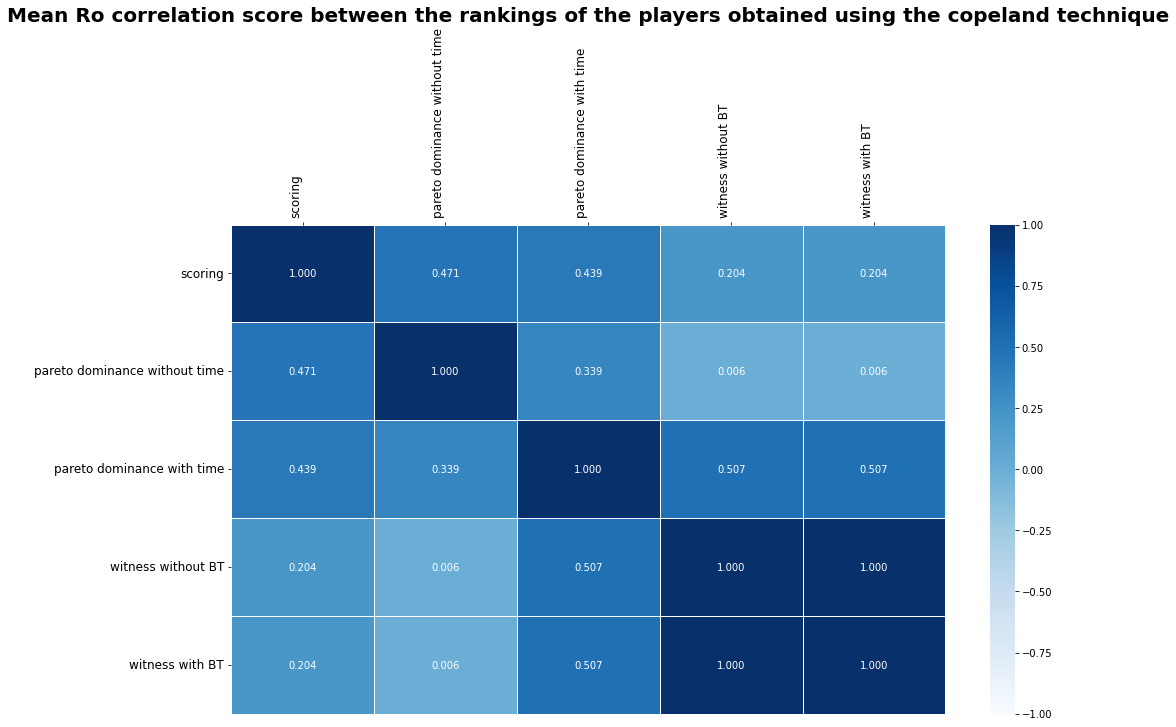

In [63]:
display_heatmap(np.round(global_ro_copeland, 4), index,
                f"Mean Ro correlation score between the rankings of the players obtained using the copeland technique")

In [51]:
global_tau_borda, global_ro_borda = generate_global_tau_ro_matrix_for_one_specific_method(2)

100%|███████████████████████████████████████████| 30/30 [00:34<00:00,  1.16s/it]


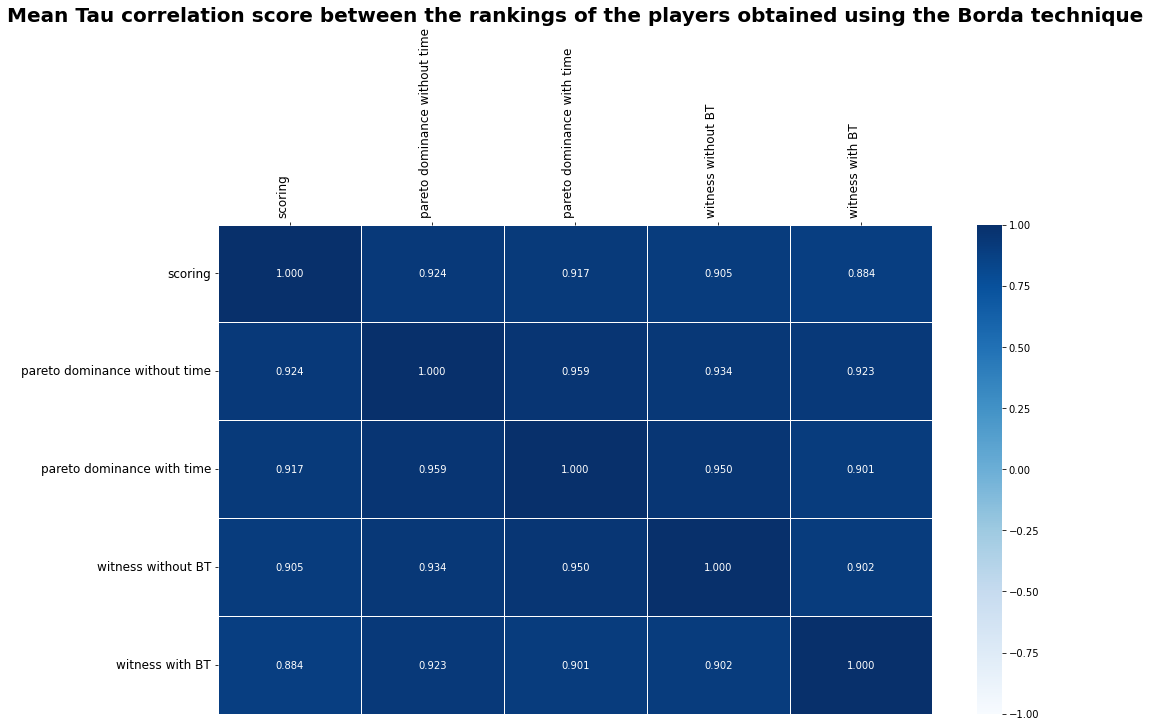

In [64]:
display_heatmap(np.round(global_tau_borda, 4), index,
                f"Mean Tau correlation score between the rankings of the players obtained using the Borda technique")

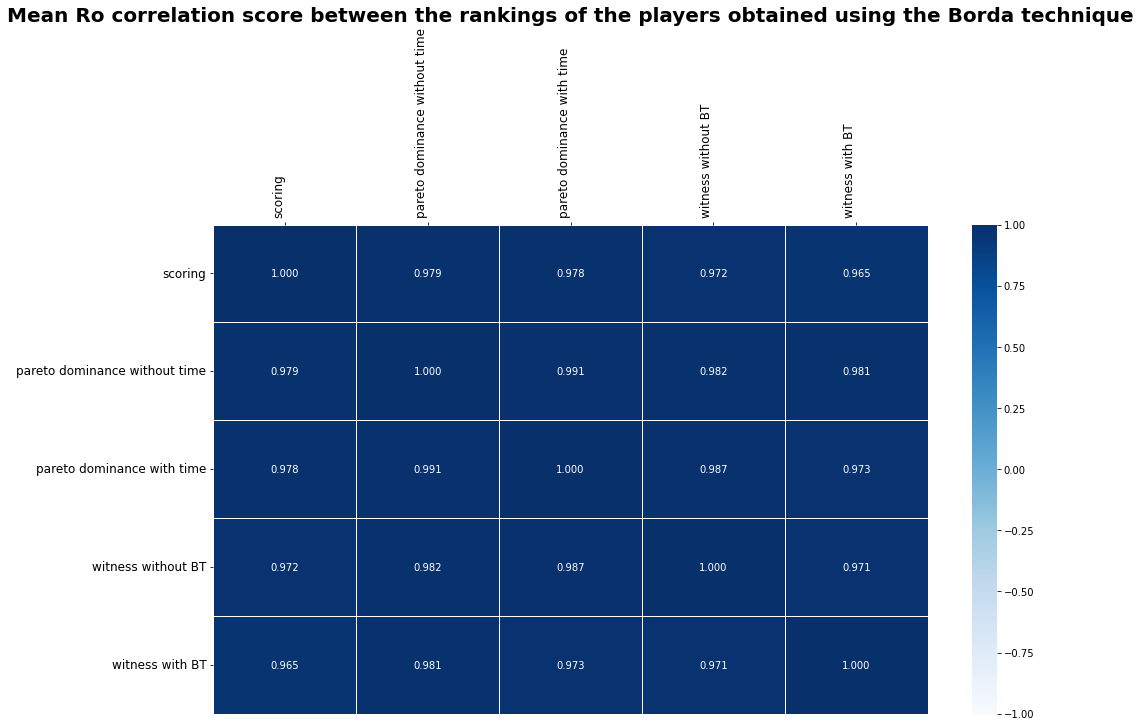

In [65]:
display_heatmap(np.round(global_ro_borda, 4), index,
                f"Mean Ro correlation score between the rankings of the players obtained using the Borda technique")

In [54]:
global_tau_stv, global_ro_stv = generate_global_tau_ro_matrix_for_one_specific_method(3)

100%|███████████████████████████████████████████| 30/30 [01:57<00:00,  3.92s/it]


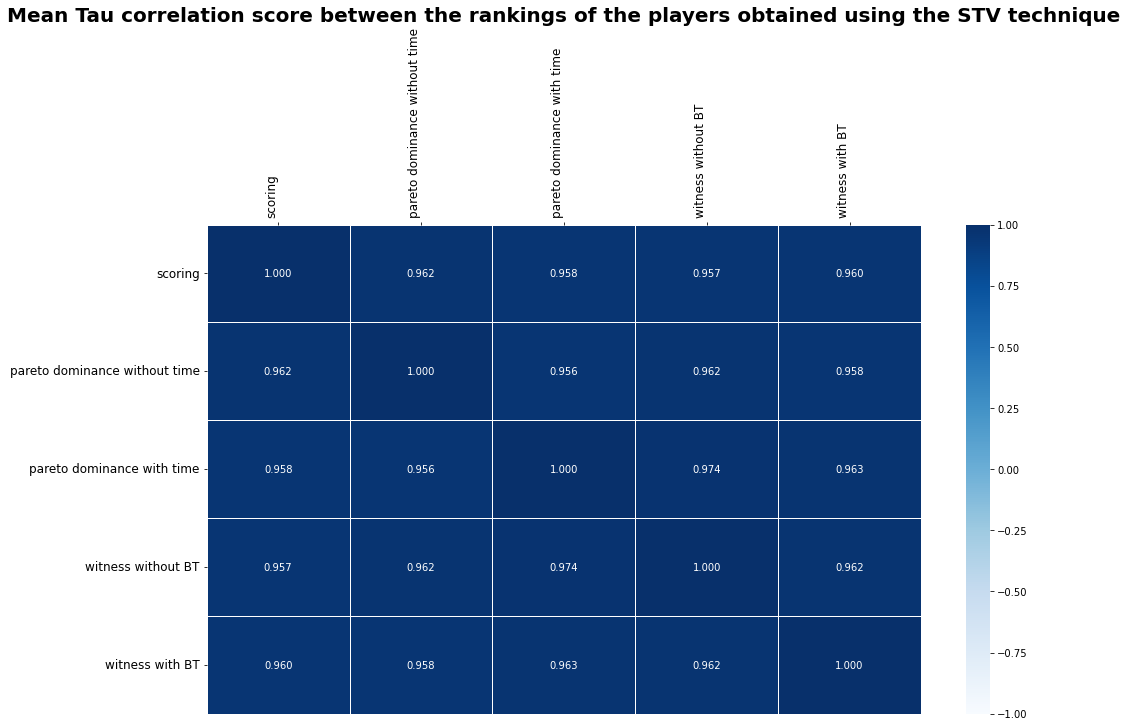

In [66]:
display_heatmap(np.round(global_tau_stv, 4), index,
                f"Mean Tau correlation score between the rankings of the players obtained using the STV technique")

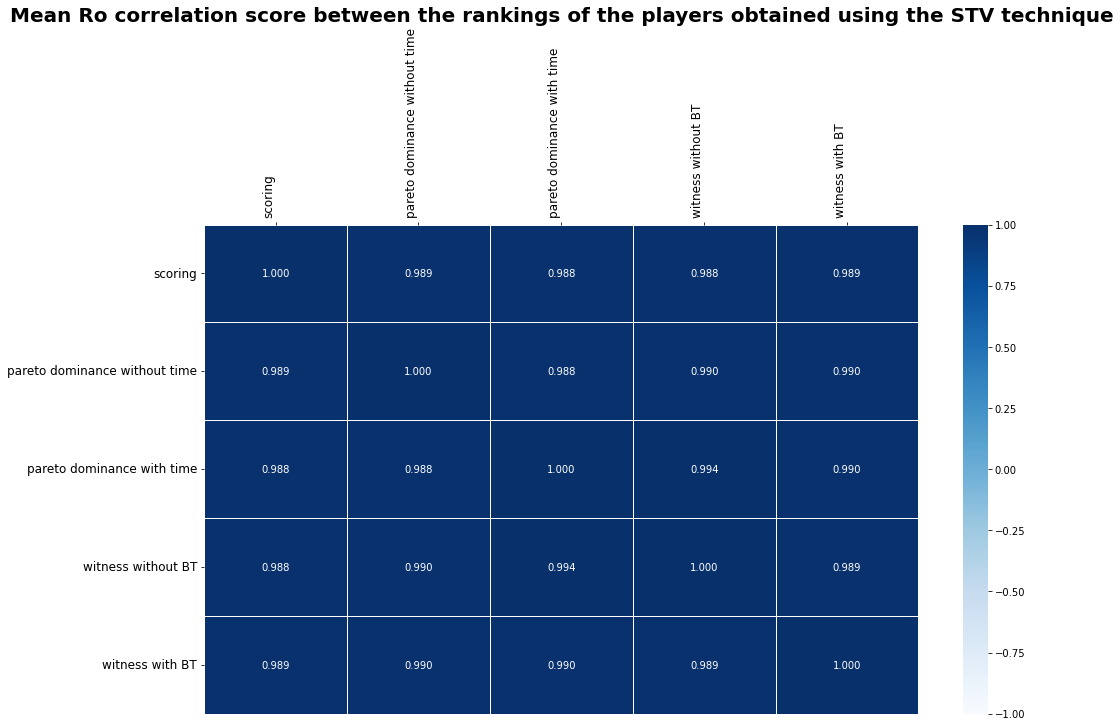

In [67]:
display_heatmap(np.round(global_ro_stv, 4), index,
                f"Mean Ro correlation score between the rankings of the players obtained using the STV technique")

## Team Focused analysis
In this section we focus on one team in particular and try to understand the impact of the way the ranking of the lineups is constructed over the ranking of the players

In [42]:
#in rder to try the same analysis on another team just change the value of the TEAM_INDEX variable
TEAM_INDEX = 0
t = teams[TEAM_INDEX]

In [69]:
#generate the matrices of correlation between the rankings of the players using all 5 approaches

fixed_team_tau_copeland, fixed_team_ro_copeland = generate_rankings(session, t,t.copeland, True, Player.ceteris_paribus)
fixed_team_tau_ks, fixed_team_ro_ks = generate_rankings(session,t ,t.krammer_simpson, True, Player.ceteris_paribus)
fixed_team_tau_borda, fixed_team_ro_borda = generate_rankings(session,t, t.borda_ranking)
fixed_team_tau_stv, fixed_team_ro_stv = generate_rankings(session,t, t.stv_based_ranking)

In [72]:
fixed_team_distance_matrix_kendall = np.zeros((NB_RANKINGS, NB_RANKINGS))
fixed_team_distance_matrix_spearman = np.zeros((NB_RANKINGS, NB_RANKINGS))

rankings, base = [],[]
tmp = t.lineup_ranking(session, "scoring", False, None, False)
tmp_ranking = []
for i in tmp.keys():
    tmp_ranking.append(tmp[i])
    for j in tmp[i]:
        base.append(j)
base = sorted(base)
rankings.append(ranking_to_ballot(tmp_ranking,base))
tmp = t.lineup_ranking(session, "pareto_dominance", False, None, False)
tmp_ranking = []
for i in tmp.keys():
    tmp_ranking.append(tmp[i])
rankings.append(ranking_to_ballot(tmp_ranking,base))

tmp = t.lineup_ranking(session, "pareto_dominance", True, None, False)
tmp_ranking = []
for i in tmp.keys():
    tmp_ranking.append(tmp[i])
rankings.append(ranking_to_ballot(tmp_ranking,base))

tmp = t.lineup_ranking(session, "witness", False, "scoring", False)
tmp_ranking = []
for i in tmp.keys():
    tmp_ranking.append(tmp[i])
rankings.append(ranking_to_ballot(tmp_ranking,base))

tmp = t.lineup_ranking(session, "witness", False, "scoring", True)
tmp_ranking = []
for i in tmp.keys():
    tmp_ranking.append(tmp[i])
rankings.append(ranking_to_ballot(tmp_ranking,base))

for i in range(len(rankings)):
    fixed_team_distance_matrix_kendall[i, i] = 1
    fixed_team_distance_matrix_spearman[i, i] = 1
    for j in range(i+1,len(rankings)):
        fixed_team_distance_matrix_kendall[i, j] += kendalltau_dist(rankings[i], rankings[j])
        fixed_team_distance_matrix_kendall[j, i] = fixed_team_distance_matrix_kendall[i, j]
        fixed_team_distance_matrix_spearman[i, j] += spearman_ro(rankings[i], rankings[j])
        fixed_team_distance_matrix_spearman[j, i] = fixed_team_distance_matrix_spearman[i, j]


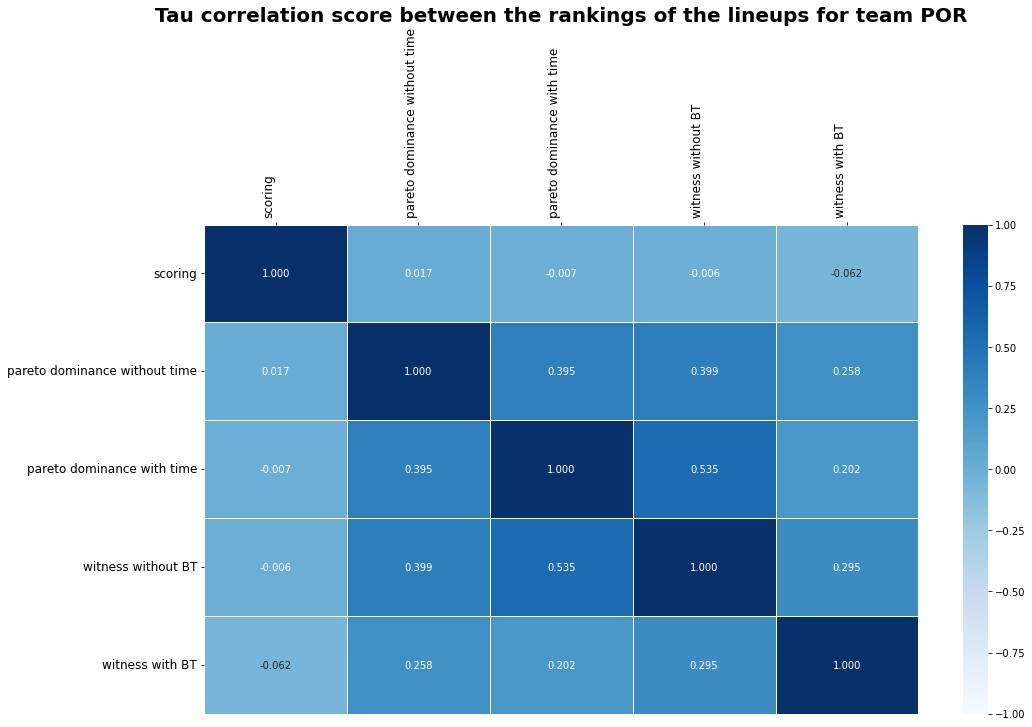

In [73]:
display_heatmap(np.round(fixed_team_distance_matrix_kendall, 4), index,
                f"Tau correlation score between the rankings of the lineups for team {t.team_name}")

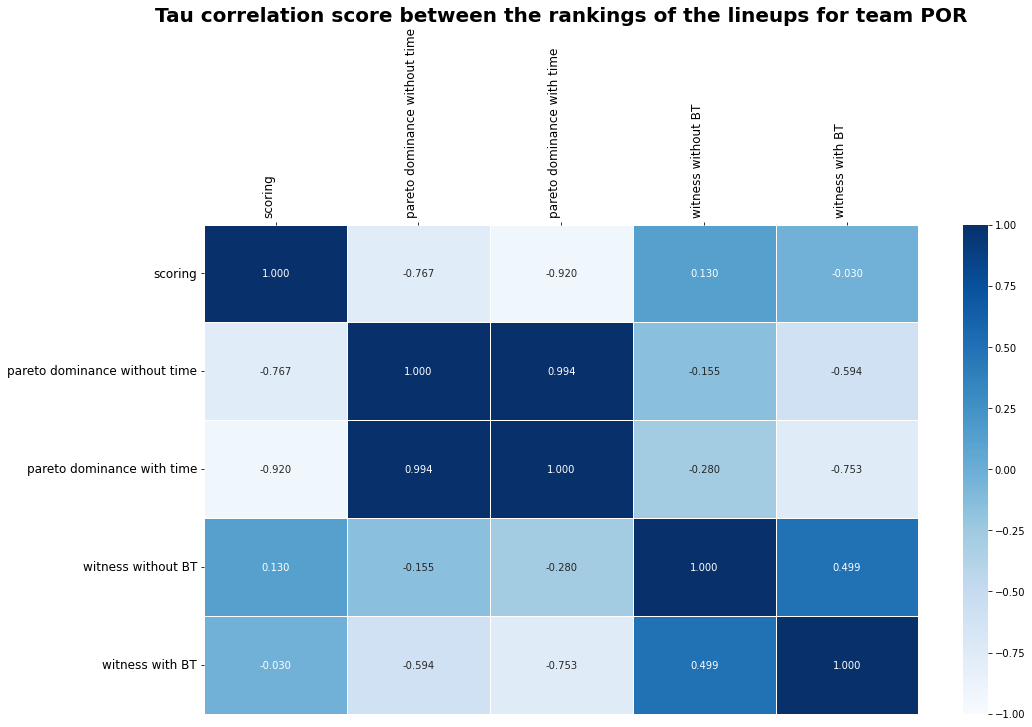

In [75]:
display_heatmap(np.round(fixed_team_distance_matrix_spearman, 4), index,
                f"Ro correlation score between the rankings of the lineups for team {t.team_name}")

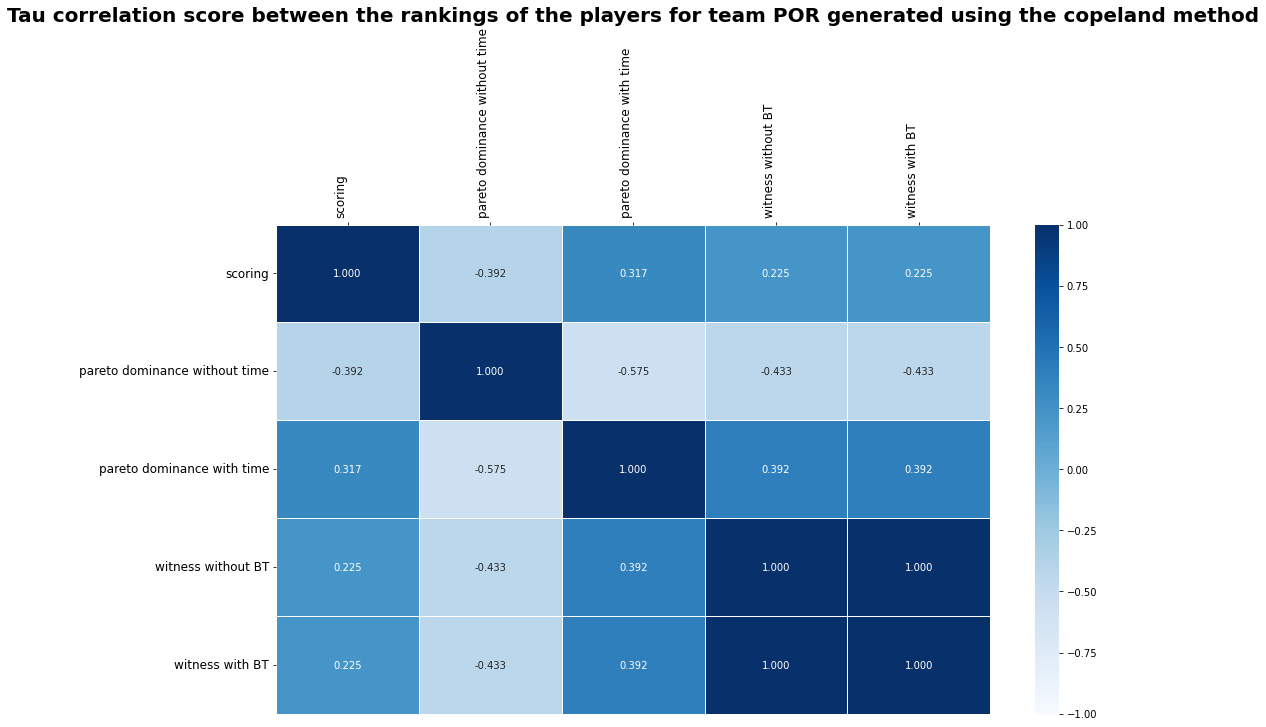

In [74]:
display_heatmap(np.round(tau_copeland, 4), index,
                f"Tau correlation score between the rankings of the players for team {t.team_name} generated using the copeland method")

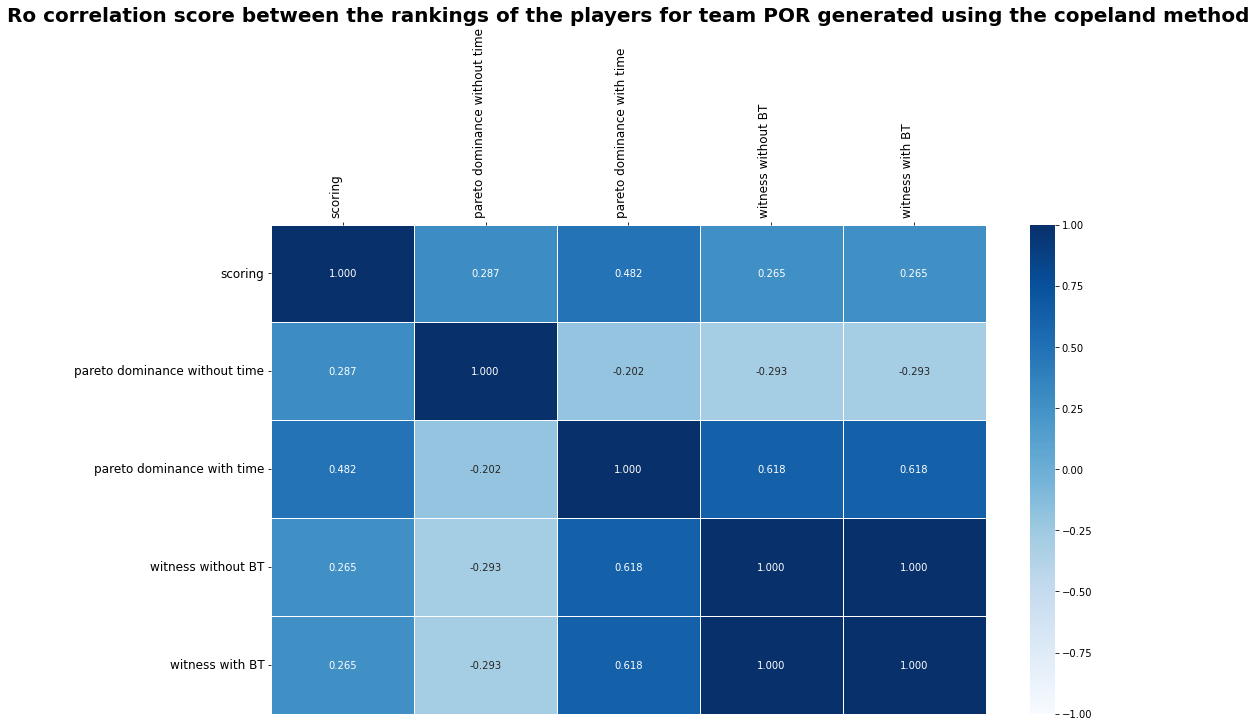

In [76]:
display_heatmap(np.round(ro_copeland, 4), index,
                f"Ro correlation score between the rankings of the players for team {t.team_name} generated using the copeland method")